# Concept drift detection with respect to AVClass2 labels

In this notebook concept drift detection is performed, after an initial phase of Alpha assessment.
Concept drift is analyzed both for families already seen in the training set and unseen families.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import transcend.data as data
from dataset.malware_dataset import MalwareDataset

In [2]:
base_path = "/home/luca/ml-malware-concept-drift/src/notebooks/"

# Load Full Dataset with Malware Static Features
malware_dataset = MalwareDataset(
    split=pd.Timestamp("2021-09-03 13:47:49"),
    truncated_fam_path="truncated_samples_per_family.csv",
    truncated_threshold=7,
)

print("Loading malw-static-features training features...")
full_dataset_path = base_path + "clustering/1_preprocessing/X_nontrunc_norm.pickle"
X = data.load_cached_data(full_dataset_path)

X_train, X_test = (
    X.loc[malware_dataset.training_dataset["sha256"]],
    X.loc[malware_dataset.testing_dataset["sha256"]],
)
y_train, y_test = (
    malware_dataset.training_dataset["family"],
    malware_dataset.testing_dataset["family"],
)

# Convert family labels to integers (needed for RF NCM)
all_labels = pd.concat([y_train, y_test]).unique()
y_train = pd.Categorical(y_train, categories=all_labels).codes
y_test = pd.Categorical(y_test, categories=all_labels).codes

all_y_test = malware_dataset.testing_dataset["family"].unique()
all_y_train = malware_dataset.training_dataset["family"].unique()

families_in_test_not_train = np.setdiff1d(all_y_test, all_y_train)
testing_dataset = malware_dataset.testing_dataset

shas_test_app_fam = testing_dataset[
    testing_dataset["family"].isin(families_in_test_not_train)
]["sha256"]
X_test_new_fam = X.loc[shas_test_app_fam]

del X

test_size = 0.34

Loading malw-static-features training features...


In [3]:
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(
    X_train, y_train, test_size=test_size, random_state=3
)

X_proper_train.shape, X_cal.shape

((24702, 46096), (12726, 46096))

In [4]:
cal_results_name = "./models/ice-malw-static-features/cal_results.p"
cal_results = data.load_cached_data(cal_results_name)

In [5]:
model_name = "./models/ice-malw-static-features/rf_cal_fold_ice_0.34.p"
rf = data.load_cached_data(model_name)

In [6]:
y_cal_predict = rf.predict(X_cal)

## Alpha Assessment

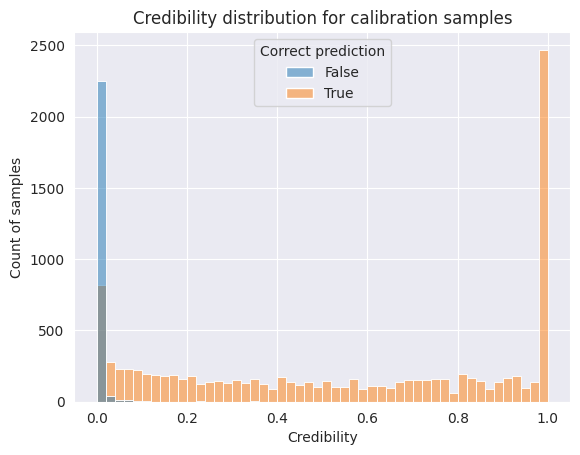

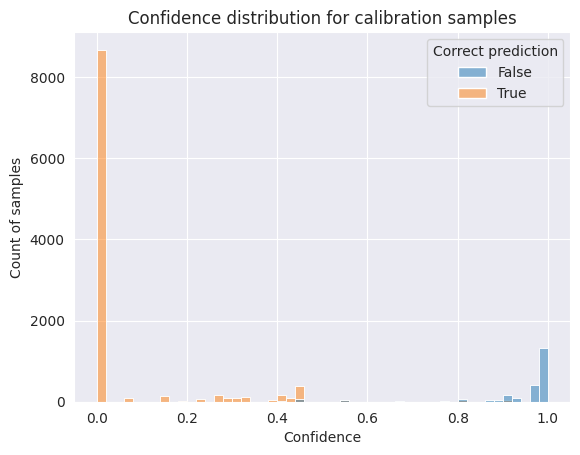

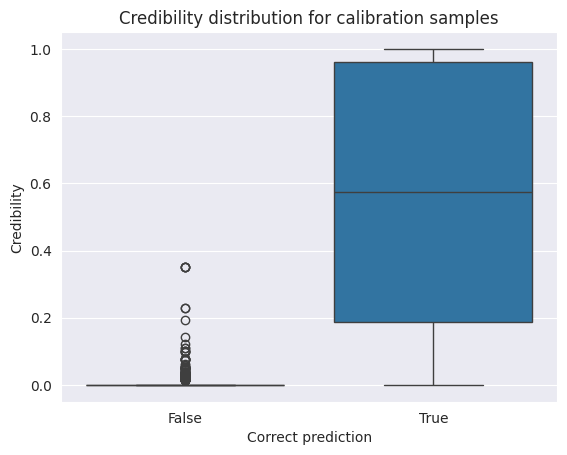

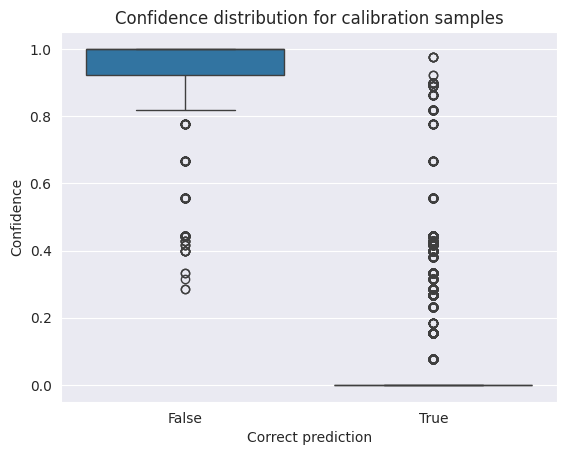

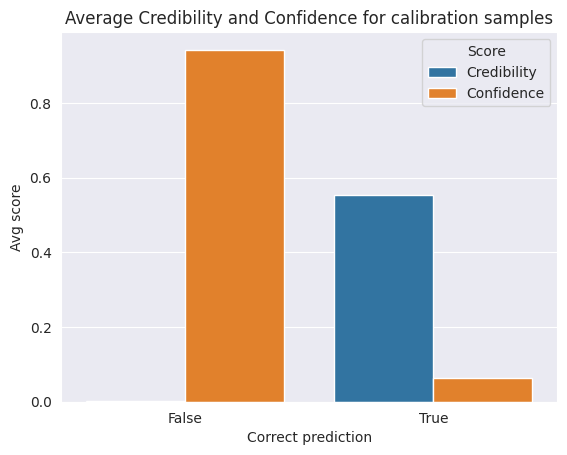

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

p_value_cal_dist = pd.DataFrame(
    {
        "cal_cred": cal_results["cred_p_val_cal"],
        "cal_conf": cal_results["conf_p_val_cal"],
        "Correct prediction": y_cal == y_cal_predict,
    }
)

plt.figure()
plt.title("Credibility distribution for calibration samples")
sns.histplot(p_value_cal_dist, x="cal_cred", hue="Correct prediction", bins=50)
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
# plt.axvline(x=0.05, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
plt.show()

plt.figure()
plt.title("Confidence distribution for calibration samples")
sns.histplot(p_value_cal_dist, x="cal_conf", hue="Correct prediction", bins=50)
plt.xlabel("Confidence")
plt.ylabel("Count of samples")
plt.show()

# avg_cred_correct = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == True])
# avg_cred_incorrect = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == False])
#
# print(avg_cred_correct, avg_cred_incorrect)
plt.figure()
plt.title("Credibility distribution for calibration samples")
sns.boxplot(p_value_cal_dist, y="cal_cred", x="Correct prediction", orient="v")
plt.ylabel("Credibility")
plt.show()

plt.figure()
plt.title("Confidence distribution for calibration samples")
sns.boxplot(p_value_cal_dist, y="cal_conf", x="Correct prediction", orient="v")
plt.ylabel("Confidence")
plt.show()

cal_cred_corr_avg = np.mean(
    p_value_cal_dist[p_value_cal_dist["Correct prediction"]]["cal_cred"]
)
cal_cred_incorr_avg = np.mean(
    p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_cred"]
)

cal_conf_corr_avg = np.mean(
    p_value_cal_dist[p_value_cal_dist["Correct prediction"]]["cal_conf"]
)
cal_conf_incorr_avg = np.mean(
    p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_conf"]
)

df_avg = pd.DataFrame(
    {
        "avg": [
            cal_cred_corr_avg,
            cal_conf_corr_avg,
            cal_cred_incorr_avg,
            cal_conf_incorr_avg,
        ],
        "Correct prediction": [True, True, False, False],
        "Score": ["Credibility", "Confidence", "Credibility", "Confidence"],
    }
)

plt.figure()
plt.title("Average Credibility and Confidence for calibration samples")
sns.barplot(df_avg, x="Correct prediction", y="avg", hue="Score")
plt.ylabel("Avg score")
plt.show()

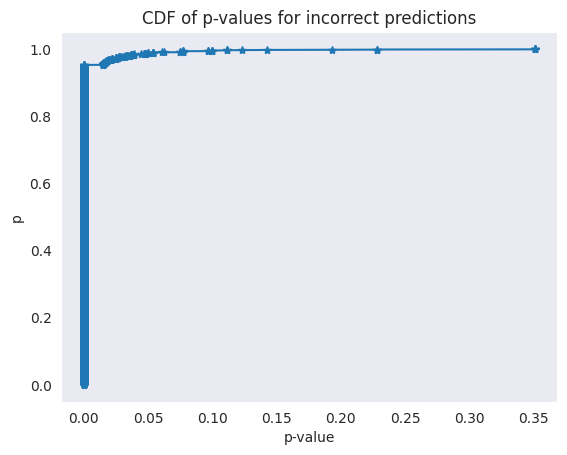

It's possible to see that there's a huge elbow after p-value 0. We could select this number as the threshold, but in concept drift detection applied to malware samples we rather prefer to detect false positives than false negatives. Using the classic threshold of 0.05, we can see that 98.62 % of incorrect choices have p-value < 0.05. This threshold has been considered acceptable for the problem, as it covers even more samples.


In [8]:
def compute_cdf(data):
    data_sorted = np.sort(data)
    p = 1.0 * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
    return data_sorted, p


cred_cdf = compute_cdf(
    list(p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_cred"])
)

threshold = 0.05
focus_p, focus_p_value = (
    cred_cdf[1][cred_cdf[0] < threshold],
    cred_cdf[0][cred_cdf[0] < threshold],
)

elbow_p, elbow_p_value = (
    focus_p[len(focus_p) - 1],
    focus_p_value[len(focus_p_value) - 1],
)

plt.figure()
plt.title("CDF of p-values for incorrect predictions")
plt.plot(cred_cdf[0], cred_cdf[1], marker="*")
plt.xlabel("p-value")
plt.ylabel("p")
plt.grid()
plt.show()

print(
    "It's possible to see that there's a huge elbow after p-value 0. "
    "We could select this number as the threshold, but in concept drift detection applied to malware samples we rather prefer to detect false positives than false negatives. Using the classic threshold of 0.05, we can see that",
    f"{round(elbow_p * 100, 2)} % of incorrect choices have p-value < {threshold}. This threshold has been considered acceptable for the problem, as it covers even more samples.",
)

In [9]:
del cal_results, rf, X_proper_train, y_proper_train

## Concept drift detection of seen families

Leveraging the threshold identified in the previous point, concept drift detection is carried out.

In [10]:
test_results_name = "./models/ice-malw-static-features/p_vals_ncms_rf_full_test.p"
test_results = data.load_cached_data(test_results_name)

In [11]:
model_name = "./models/ice-malw-static-features/rf_ice_full_train_deploy.p"
rf_full = data.load_cached_data(model_name)

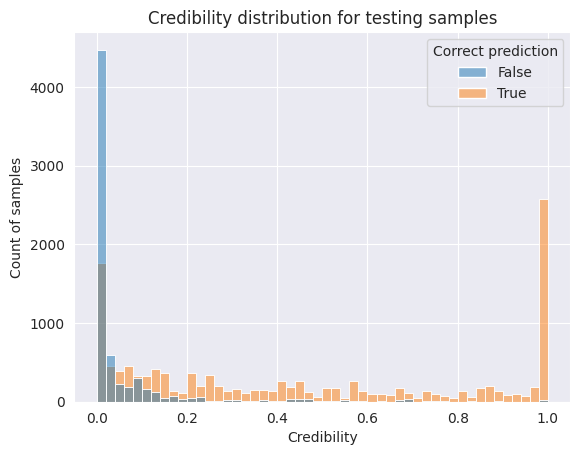

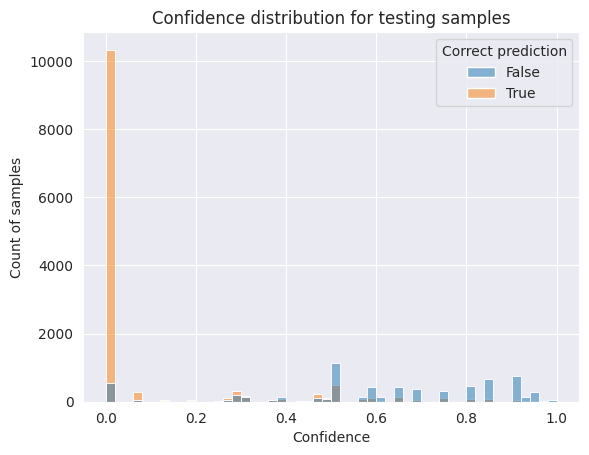

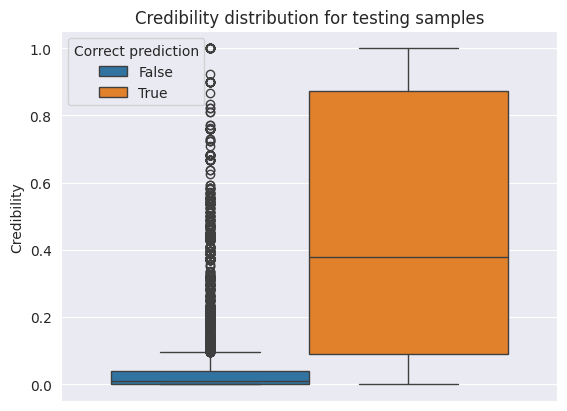

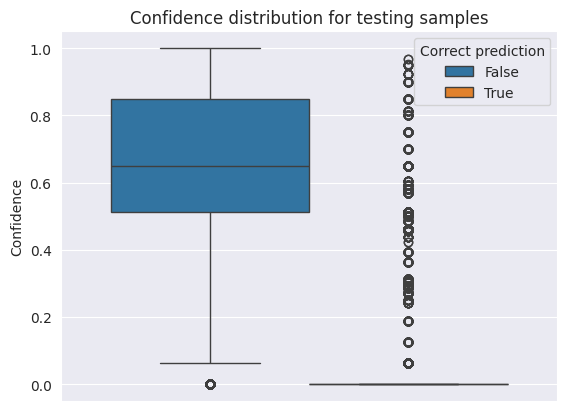

In [49]:
y_test_predict = rf_full.predict(X_test)

label_mapping = {i: label for i, label in enumerate(all_labels)}

df_test_results = pd.DataFrame(
    {
        "test_cred": test_results["cred"],
        "test_conf": test_results["conf"],
        "family": [label_mapping[f] for f in y_test],
        "family_pred": [label_mapping[f] for f in y_test_predict],
        "is_family_in_train": [y in y_train for y in y_test],
        "Correct prediction": y_test == y_test_predict,
    }
)

df_fam_evolution = df_test_results[df_test_results["is_family_in_train"]]

plt.figure()
plt.title("Credibility distribution for testing samples")
sns.histplot(df_fam_evolution, x="test_cred", hue="Correct prediction", bins=50)
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
plt.show()

plt.figure()
plt.title("Confidence distribution for testing samples")
sns.histplot(df_fam_evolution, x="test_conf", hue="Correct prediction", bins=50)
plt.xlabel("Confidence")
plt.ylabel("Count of samples")
plt.show()

# avg_cred_correct = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == True])
# avg_cred_incorrect = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == False])
#
# print(avg_cred_correct, avg_cred_incorrect)
plt.figure()
plt.title("Credibility distribution for testing samples")
sns.boxplot(df_fam_evolution, y="test_cred", hue="Correct prediction", orient="v")
plt.legend(title="Correct prediction")
plt.ylabel("Credibility")
plt.show()

plt.figure()
plt.title("Confidence distribution for testing samples")
sns.boxplot(df_fam_evolution, y="test_conf", hue="Correct prediction", orient="v")
plt.legend(title="Correct prediction")
plt.ylabel("Confidence")
plt.show()

In [86]:
df_test_results_inc_no_drift = df_fam_evolution[(~df_fam_evolution["Correct prediction"]) &
                                                (df_fam_evolution["test_cred"] >= threshold)]

df_test_results_inc_no_drift.loc[:, "family_pred"] = df_test_results_inc_no_drift["family_pred"].astype(str).str.strip()
df_test_results_inc_no_drift.loc[:, "family"] = df_test_results_inc_no_drift["family"].astype(str).str.strip()

n_inc_no_drift = df_test_results_inc_no_drift.shape[0]

print(f"{n_inc_no_drift} ({round(n_inc_no_drift / len(df_fam_evolution) * 100, 2)}%) testing samples (belonging to seen families) have incorrect prediction but high credibility.")

n_families_inc_no_drift = df_test_results_inc_no_drift["family"].unique().shape[0]

print(f"These samples belong to {n_families_inc_no_drift} distinct families")

df = df_test_results_inc_no_drift.groupby(by="family")["family_pred"].nunique().reset_index()
avg_num_fam_pred_per_fam = df["family_pred"].mean()

print(f"On average, each true family is predicted to {round(avg_num_fam_pred_per_fam, 2)} different families.")

1568 (7.93%) testing samples (belonging to seen families) have incorrect prediction but high credibility.
These samples belong to 190 distinct families
On average, each true family is predicted to 1.78 different families.


In [13]:
unique_drift_families, num_drifted_samples = np.unique(
    list(df_fam_evolution[df_fam_evolution["test_cred"] < 0.05]["family"]),
    return_counts=True,
)

# plt.bar(unique_drift_families, num_drifted_samples)
print(
    f"A total of {sum(num_drifted_samples)} testing points are drifting "
    f"({round(sum(num_drifted_samples) / len(df_fam_evolution) * 100, 2)} % of testing points)"
)

A total of 7648 testing points are drifting (38.68 % of testing points)


In [14]:
from sklearn.metrics import accuracy_score

y_test_seen_fam, y_test_seen_fam_pred = (
    y_test[[y in y_train for y in y_test]],
    y_test_predict[[y in y_train for y in y_test]],
)

testing_acc = accuracy_score(y_test_seen_fam, y_test_seen_fam_pred)
print(
    f"Random Forest classifier has {round(testing_acc * 100, 2)} % accuracy over the testing set"
)

Random Forest classifier has 66.01 % accuracy over the testing set


In [15]:
df_drift = pd.DataFrame(
    {
        "family": unique_drift_families,
        "num_test_drifted": num_drifted_samples,
    }
)
df_drift.set_index("family", inplace=True)

In [16]:
print(
    f"Drifted samples belongs to {df_drift.shape[0]} different families "
    f"({round(df_drift.shape[0] / len(np.unique(y_test_seen_fam)) * 100, 2)} % "
    f"of the families present in the testing set)"
)

Drifted samples belongs to 451 different families (84.46 % of the families present in the testing set)


In [17]:
uniq_fam_test, count_test_fam = np.unique(y_test_seen_fam, return_counts=True)
df_uniq_fam_test = pd.DataFrame({"family": uniq_fam_test, "count": count_test_fam})
df_uniq_fam_test.set_index("family", inplace=True)

df_drift_cmp = df_drift.join(df_uniq_fam_test)

fam_with_complete_drift = df_drift_cmp[
    df_drift_cmp["num_test_drifted"] == df_drift_cmp["count"]
    ]
print(
    f"A total of {fam_with_complete_drift.shape[0]} families have all drifting testing samples."
)

A total of 45 families have all drifting testing samples.


In [18]:
# Map the encoded values back to the original labels
drifted_families = [
    label_mapping[family_id] for family_id in fam_with_complete_drift.index
]
fam_with_complete_drift.index = drifted_families

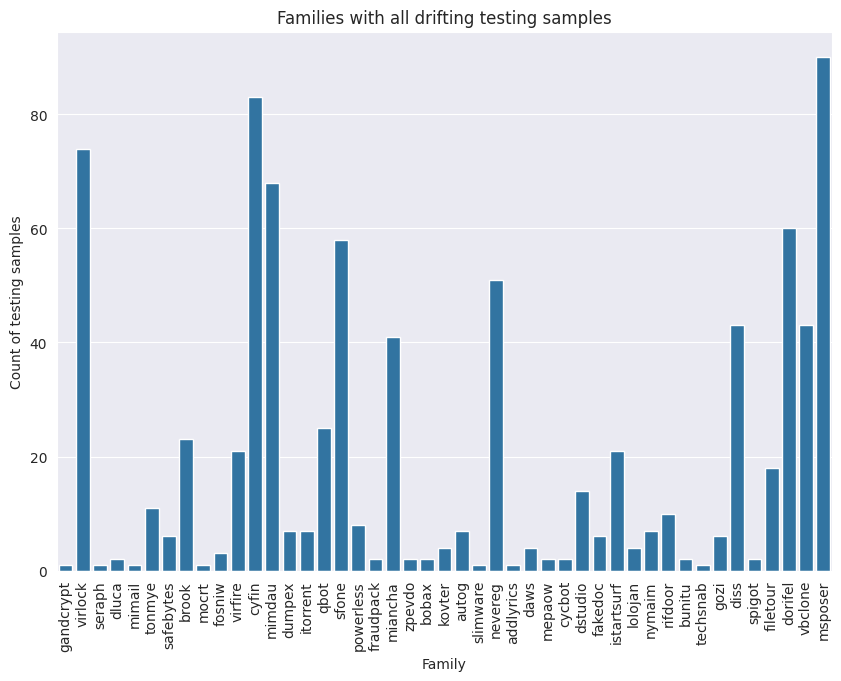

In [19]:
plt.figure(figsize=(10, 7))
plt.title("Families with all drifting testing samples")
sns.barplot(x=fam_with_complete_drift.index, y=fam_with_complete_drift["count"])
plt.xlabel("Family")
plt.ylabel("Count of testing samples")
plt.xticks(rotation=90)
plt.show()

In [20]:
n_over_rep_families = len(
    fam_with_complete_drift[fam_with_complete_drift["count"] <= 20]
)
print(
    f"Most of the drifting families have more than 80% of the points in the training dataset: "
    f"{n_over_rep_families} ({round(n_over_rep_families / len(fam_with_complete_drift) * 100, 2)}%), specifically"
)

Most of the drifting families have more than 80% of the points in the training dataset: 31 (68.89%), specifically


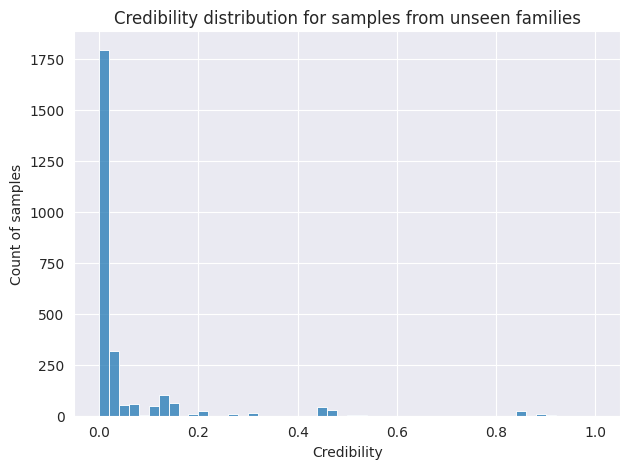

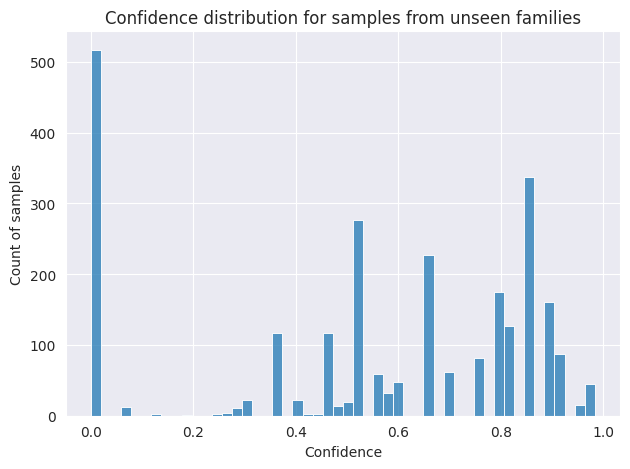

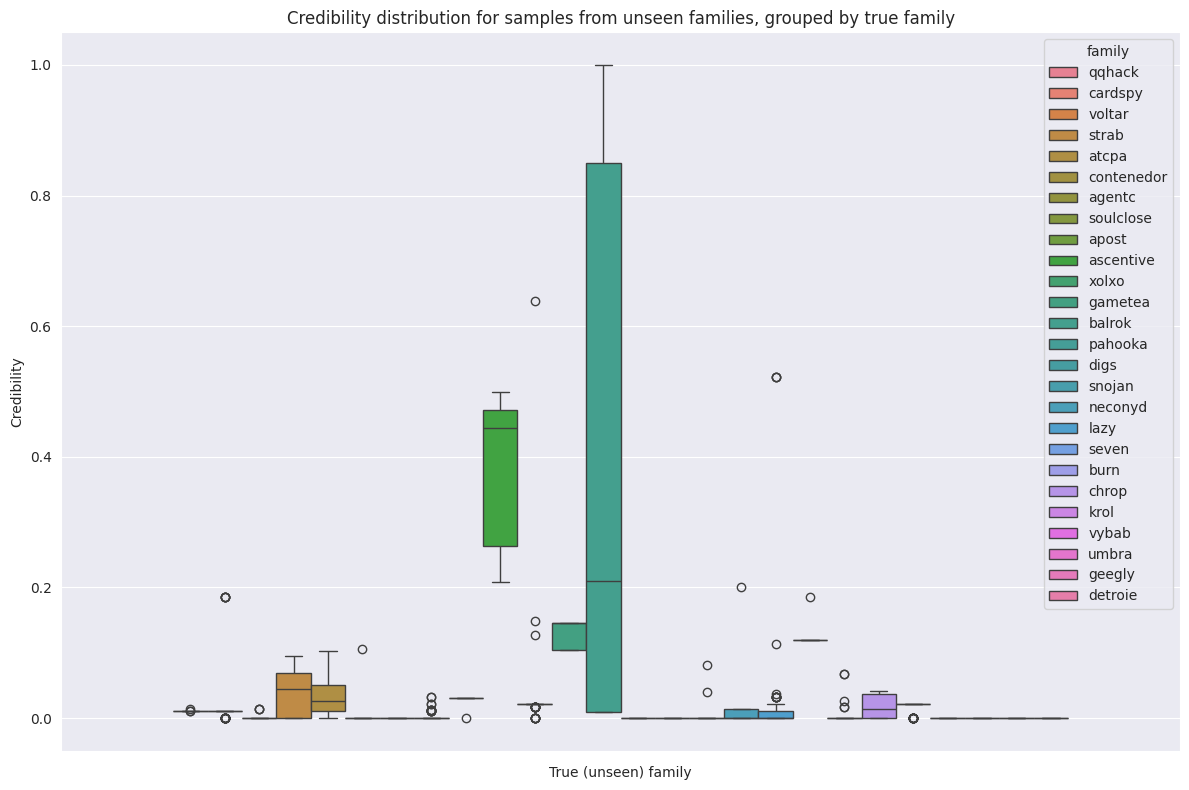

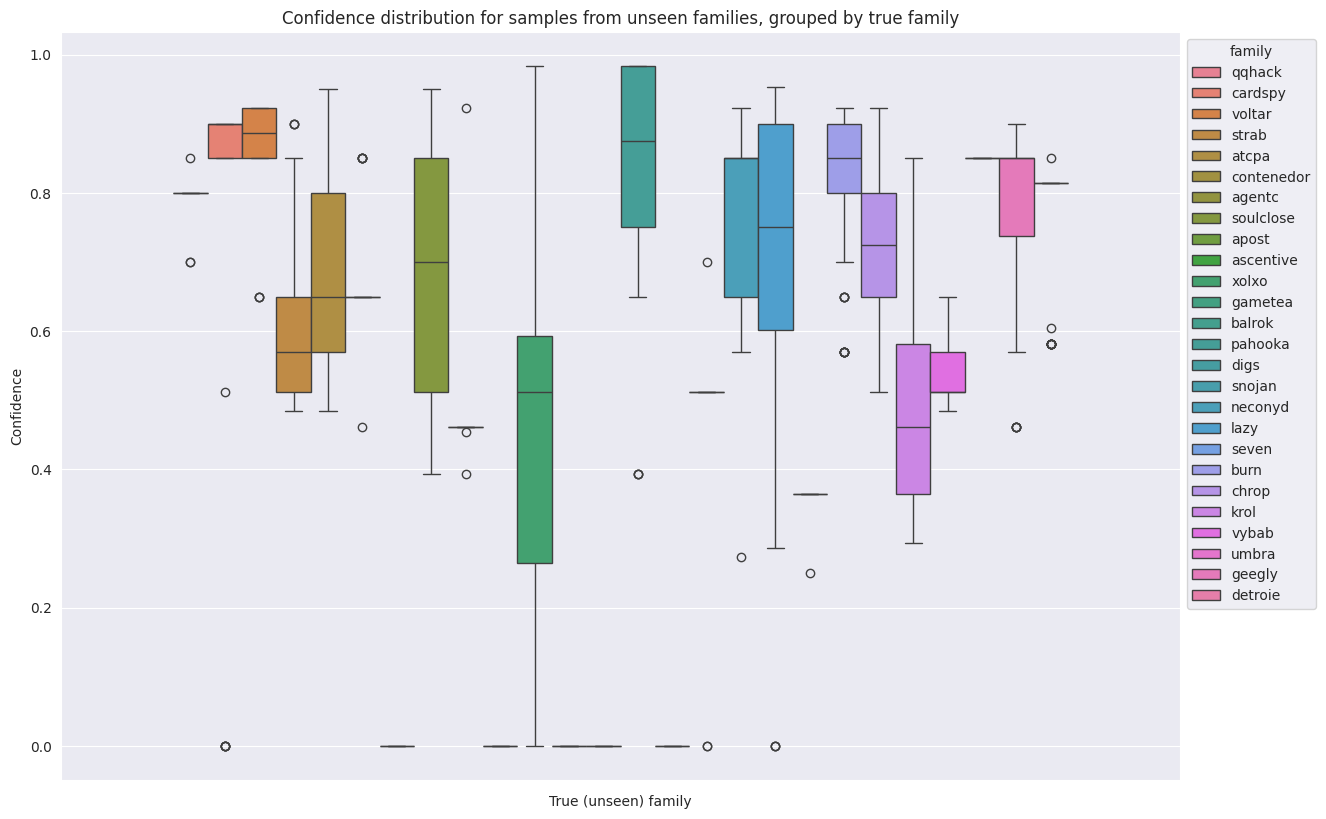

In [21]:
y_test_app_fam_pred_codes = rf_full.predict(X_test_new_fam)
y_test_app_fam_pred = pd.Categorical.from_codes(
    y_test_app_fam_pred_codes, categories=all_labels
)

label_mapping = {i: label for i, label in enumerate(all_labels)}

df_unseen_fam_1 = df_test_results[~df_test_results["is_family_in_train"]]
df_unseen_fam = df_unseen_fam_1.copy()
df_unseen_fam["family"] = df_unseen_fam_1["family"].map(lambda f: label_mapping[f])
df_unseen_fam["family_pred"] = y_test_app_fam_pred

del df_unseen_fam_1

plt.title("Credibility distribution for samples from unseen families")
sns.histplot(df_unseen_fam, x="test_cred", bins=50)
plt.tight_layout()
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
plt.show()

plt.title("Confidence distribution for samples from unseen families")
sns.histplot(df_unseen_fam, x="test_conf", bins=50)
plt.tight_layout()
plt.ylabel("Count of samples")
plt.xlabel("Confidence")
plt.show()

plt.figure(figsize=(12, 8))
plt.title(
    "Credibility distribution for samples from unseen families, grouped by true family"
)
box = sns.boxplot(df_unseen_fam, y="test_cred", hue="family", orient="v")
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.tight_layout()
sns.move_legend(box, "best", bbox_to_anchor=(1, 1))

plt.show()

plt.figure(figsize=(12, 8))
plt.title(
    "Confidence distribution for samples from unseen families, grouped by true family"
)
box = sns.boxplot(df_unseen_fam, y="test_conf", hue="family", orient="v")
plt.tight_layout()
plt.xlabel("True (unseen) family")
plt.ylabel("Confidence")
sns.move_legend(box, "best", bbox_to_anchor=(1, 1))
plt.show()

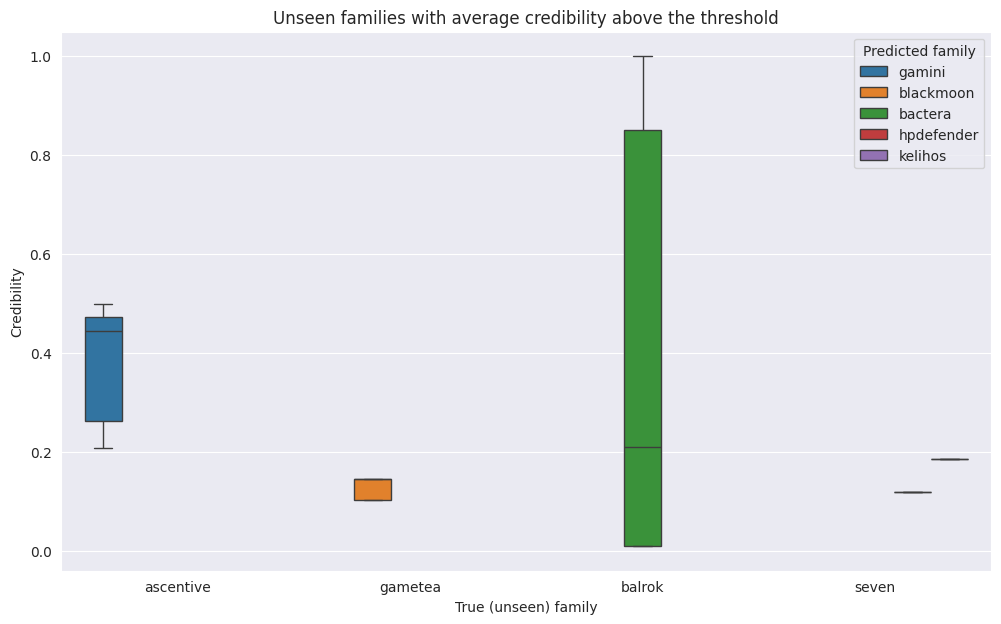

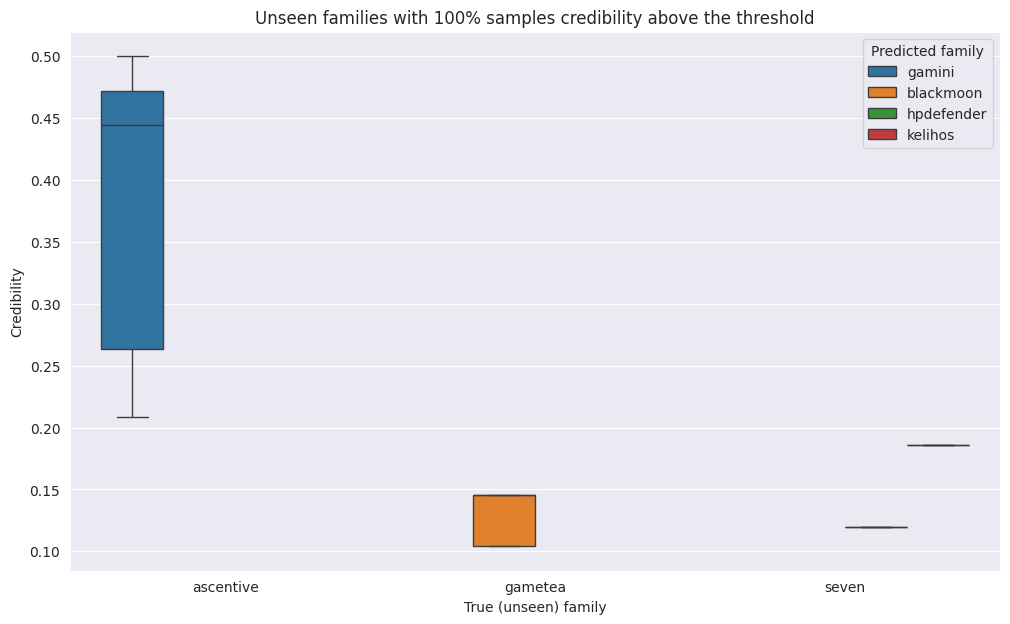

In [22]:
families_with_high_cred, families_with_all_high_cred = [], []
for family in families_in_test_not_train:
    df_sub = df_unseen_fam[df_unseen_fam["family"] == family]
    if np.mean(df_sub["test_cred"]) >= threshold:
        df_sub.loc[:, "family_pred"] = df_sub["family_pred"].astype(str).str.strip()
        families_with_high_cred.append(family)
    if (df_sub["test_cred"] >= threshold).all():
        families_with_all_high_cred.append(family)

plt.figure(figsize=(12, 7))
plt.title("Unseen families with average credibility above the threshold")
df_sub = df_unseen_fam[df_unseen_fam["family"].isin(families_with_high_cred)]

df_sub_new = df_sub.copy()
df_sub_new["family_pred"] = df_sub["family_pred"].astype(str).str.strip()

box = sns.boxplot(df_sub_new, x="family", y="test_cred", hue="family_pred", orient="v")
sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.legend(title="Predicted family")
plt.show()

plt.figure(figsize=(12, 7))
plt.title("Unseen families with 100% samples credibility above the threshold")
df_sub = df_unseen_fam[df_unseen_fam["family"].isin(families_with_all_high_cred)]

df_sub_new = df_sub.copy()
df_sub_new["family_pred"] = df_sub["family_pred"].astype(str).str.strip()

box = sns.boxplot(df_sub_new, x="family", y="test_cred", hue="family_pred", orient="v")
sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
plt.legend(title="Predicted family")
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.show()